# 1) Load Data and Libraries

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/MNIST_data/", one_hot=True)
from src.classifyMNIST import *
import matplotlib.pyplot as plt
%matplotlib inline

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


# 2) Parse Out Desired Digits- 0 v 4 v 7

In [2]:
allowed_classes = [0, 4, 7]
RD = Reduce_DataSet(mnist, allowed_classes)

In [3]:
X_train, y_train_old = RD.reduce_train_test_set()
X_test, y_test_old = RD.reduce_train_test_set(False)

In [4]:
y_train = RD.fix_y_encoding()
y_test = RD.fix_y_encoding(False)

## Plot Some of the Train Data to verify correct Parsing

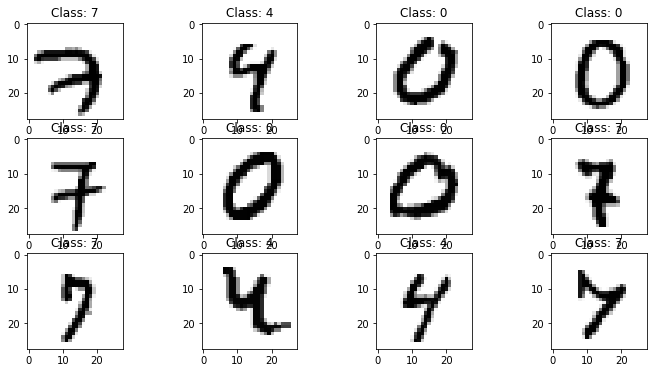

In [5]:
p = Plot(X_train, y_train_old)
fig, axs = plt.subplots(3, 4, figsize=(12, 6))

p.plot_images(axs)

# 3) Create the Model

In [6]:
num_pixels = X_train.shape[1]
num_classes = len(allowed_classes)
print ('Number of features: {}\n Number of classes: {}'.format(num_pixels, num_classes))

Number of features: 784
 Number of classes: 3


In [7]:
x_tf = tf.placeholder(tf.float32, [None, num_pixels])
y_tf = tf.placeholder(tf.float32, [None, num_classes])
W = tf.Variable(tf.zeros([num_pixels, num_classes]))
b = tf.Variable(tf.zeros([num_classes]))
y_hat = tf.matmul(x_tf, W) + b
y_hat_proba = tf.nn.softmax(y_hat)

# 4) Define Loss and Optimizer 

The raw formulation of cross-entropy, 

    tf.reduce_mean(-tf.reduce_sum(y_tf * tf.log(tf.nn.softmax(y_hat), reduction_indices=[1])))

can be numerically unstable.

So here we use tf.nn.softmax_cross_entropy_with_logits on the ray outputs of 'y_hat', and then average them across the batch

In [8]:
cross_entropy = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels= y_tf, logits= y_hat))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

## Initialize Training Accuracy Tensors

In [9]:
correct_preds = tf.equal(tf.argmax(y_tf, 1), tf.argmax(y_hat, 1))
accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))

In [10]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

# 5) Train Model

Note: We will not use entire training set above, but rather only look at one "batch" at a time. 
    * Parse out desired digits (0s and 4s and 7s) for each "batch"

In [11]:
for i in range(1000):
    batch_imgs, batch_labels = mnist.train.next_batch(100)
    xs, ys_old_hot_encode = RD.reduce_train_test_set()
    ys = RD.fix_y_encoding()
    [train_accuracy] = sess.run([accuracy], feed_dict= {x_tf: xs, y_tf: ys})
    if i % 100 == 0:
        print ("Step {}, train accuracy {:0.3f}".format(i, train_accuracy))
    sess.run(train_step, feed_dict={x_tf: xs.reshape(-1, num_pixels), y_tf: ys.reshape(-1, num_classes)})    

Step 0, train accuracy 0.331
Step 100, train accuracy 0.987
Step 200, train accuracy 0.988
Step 300, train accuracy 0.989
Step 400, train accuracy 0.990
Step 500, train accuracy 0.990
Step 600, train accuracy 0.990
Step 700, train accuracy 0.991
Step 800, train accuracy 0.991
Step 900, train accuracy 0.991


# 6) Evaluate Model

In [13]:
pred_probs = y_hat_proba.eval(feed_dict= {x_tf: X_test.reshape(-1, num_pixels), 
                                          y_tf: y_test.reshape(-1, num_classes)})
pred_probs[:5, :] 

array([[  1.69055333e-04,   5.36948346e-06,   9.99825656e-01],
       [  9.99898911e-01,   9.19812422e-08,   1.00930498e-04],
       [  3.19543877e-04,   9.89407241e-01,   1.02732303e-02],
       [  2.44016937e-05,   9.98762131e-01,   1.21348270e-03],
       [  9.99958515e-01,   3.24546709e-05,   9.05247816e-06]], dtype=float32)

In [14]:
test_accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))
print (sess.run(test_accuracy, feed_dict= {x_tf: X_test, y_tf: y_test}))

0.99097
